# WORK IN PROGRESS 
this section is dedicated to mamba models, this is going to be a naive and slow implementation in pytorch, optimized for understanding of the underlying concepts. 

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [65]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [66]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

In [67]:
class Mamba(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(Mamba, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.A = nn.Linear(hidden_size, hidden_size)
        self.B = nn.Linear(emb_size, hidden_size)  # embedding -> hidden
        self.C = nn.Linear(hidden_size, emb_size)
        self.D = nn.Linear(emb_size, emb_size)
        self.norm = nn.LayerNorm(hidden_size)

        self.out = nn.Linear(emb_size, vocab_size)
        self.hidden_size = hidden_size

    # Intuitive implementation, but not the most efficient
    def forward(self, x):
        x = self.emb(x)
        
        outputs = []
        h = torch.zeros(x.shape[0], self.hidden_size).to(device)
        for i in range(x.shape[1]): 
            h = torch.tanh(self.B(x[:, i]) + self.A(h))
            outputs.append(self.C(h) + self.D(x[:, i]))

        return self.out(torch.stack(outputs, dim=1))

class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        h = torch.zeros(1, x.shape[0], self.rnn.hidden_size).to(device)
        out, h = self.rnn(x, h)
        return self.out(out)

from time import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for model in [RNN(emb_size=32, hidden_size=256).to(device), Mamba(emb_size=32, hidden_size=256).to(device)]:
    # compile model
    # model.compile()
    t0 = time()

    print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

    epochs = 3000
    batch_size = 128
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

    lossi = []
    vlossi = []

    for epoch in range(epochs):
        indexes = torch.randint(0, len(inputs)-batch_size, (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        if epoch % (epochs//10) == 0:
            print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
        
        # with torch.no_grad():
        #     pred = model(val_inputs.to(device))
        #     vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
        #     vlossi.append(vloss.item())

    from scipy.ndimage import gaussian_filter1d
    plt.figure(figsize=(6, 3))  
    plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
    plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
    plt.legend()

    print(f"Training time: {time()-t0:.2f} seconds")


Millions of parameters: 0.09
Epoch ___0 - Loss: 4.204
Epoch _300 - Loss: 2.484
Epoch _600 - Loss: 2.259
Epoch _900 - Loss: 2.142
Epoch 1200 - Loss: 2.093
Epoch 1500 - Loss: 1.953
Epoch 1800 - Loss: 1.954
Epoch 2100 - Loss: 1.872
Epoch 2400 - Loss: 1.842
Epoch 2700 - Loss: 1.791


KeyboardInterrupt: 

# Optimizing for speed
Mamba clearly works better than RNNs but it's going way slower

Millions of parameters: 0.09
Epoch ___0 - Loss: 4.202
Epoch _300 - Loss: 2.451
Epoch _600 - Loss: 2.180
Epoch _900 - Loss: 2.092
Epoch 1200 - Loss: 1.991
Epoch 1500 - Loss: 1.954
Epoch 1800 - Loss: 1.910
Epoch 2100 - Loss: 1.880
Epoch 2400 - Loss: 1.818
Epoch 2700 - Loss: 1.764
Training time: 6.60 seconds
Millions of parameters: 0.09
Epoch ___0 - Loss: 4.144
Epoch _300 - Loss: 2.398
Epoch _600 - Loss: 2.215
Epoch _900 - Loss: 2.000
Epoch 1200 - Loss: 1.986
Epoch 1500 - Loss: 1.942
Epoch 1800 - Loss: 1.817
Epoch 2100 - Loss: 1.823
Epoch 2400 - Loss: 1.823
Epoch 2700 - Loss: 1.789
Training time: 25.20 seconds


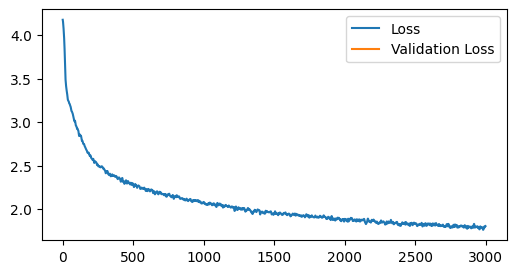

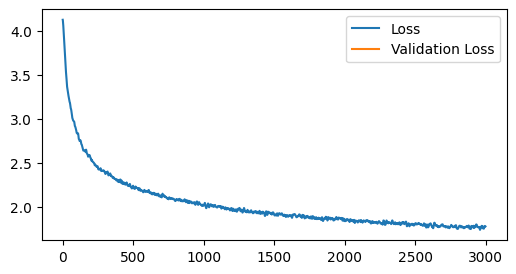

In [ ]:
class Mamba(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(Mamba, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.A = nn.Linear(hidden_size, hidden_size).weight
        self.B = nn.Linear(emb_size, hidden_size) 
        self.C = nn.Linear(hidden_size, emb_size)
        self.D = nn.Linear(emb_size, emb_size)
        self.norm = nn.LayerNorm(hidden_size)

        self.out = nn.Linear(emb_size, vocab_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = self.emb(x)
        
        outputs = []
        h = torch.zeros(x.shape[0], self.hidden_size).to(device)
        b = self.B(x)
        d = self.D(x)

        for i in range(x.shape[1]): 
            h = torch.tanh(b[:, i] + h@self.A)
            outputs.append(h)

        out = torch.stack(outputs, dim=1) 

        return self.out(self.C(out) + d)

class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        h = torch.zeros(1, x.shape[0], self.rnn.hidden_size).to(device)
        out, h = self.rnn(x, h)
        return self.out(out)

from time import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for model in [RNN(emb_size=32, hidden_size=256).to(device), Mamba(emb_size=32, hidden_size=256).to(device)]:
    # compile model
    # model.compile()
    t0 = time()

    print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

    epochs = 3000
    batch_size = 128
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

    lossi = []
    vlossi = []

    for epoch in range(epochs):
        indexes = torch.randint(0, len(inputs)-batch_size, (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        if epoch % (epochs//10) == 0:
            print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
        
        # with torch.no_grad():
        #     pred = model(val_inputs.to(device))
        #     vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
        #     vlossi.append(vloss.item())

    from scipy.ndimage import gaussian_filter1d
    plt.figure(figsize=(6, 3))  
    plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
    plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
    plt.legend()

    print(f"Training time: {time()-t0:.2f} seconds")


Using linear algebra to improve parallelization

In [ ]:
import torch

# Define a square matrix
A = torch.tensor([[4.0, 2.0],
                  [1.0, 3.0]])

# Eigen-decomposition
eigenvalues, eigenvectors = torch.linalg.eig(A)

# Construct D and P
D = torch.diag(eigenvalues.real)
P = eigenvectors.real

# Compute P^-1
P_inv = torch.linalg.inv(P)

# Verify the decomposition
A_reconstructed = P @ D @ P_inv

print("Original Matrix A:")
print(A)

print("\nDiagonal Matrix D (eigenvalues):")
print(D)

print("\nReconstructed A (should match original):")
print(A_reconstructed)


Original Matrix A:
tensor([[4., 2.],
        [1., 3.]])

Diagonal Matrix D (eigenvalues):
tensor([[5.0000, 0.0000],
        [0.0000, 2.0000]])

Reconstructed A (should match original):
tensor([[4.0000, 2.0000],
        [1.0000, 3.0000]])


In [58]:
import torch

def diagonalize(matrix):
    # Eigen-decomposition
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)

    # Construct D and P
    D = torch.diag(eigenvalues.real)
    P = eigenvectors.real

    # Compute P^-1
    P_inv = torch.linalg.inv(P)

    return P, D, P_inv

# Example usage
A = torch.tensor([[4.0, 2.0],
                  [1.0, 3.0]])

P, D, P_inv = diagonalize(A)

print("Diagonal Matrix D (eigenvalues):")
print(D)

print("\nInverse of Eigenvector Matrix P:")
print(P_inv)

Diagonal Matrix D (eigenvalues):
tensor([[5.0000, 0.0000],
        [0.0000, 2.0000]])

Inverse of Eigenvector Matrix P:
tensor([[ 0.7454,  0.7454],
        [-0.4714,  0.9428]])


In [ ]:
import torch
import time

def naive_matrix_powers(A, N):
    E = torch.zeros((N, *A.shape), dtype=A.dtype, device=A.device)
    E[0] = A.clone()
    for k in range(1, N):
        E[k] = E[k-1] @ A
    return E

def diagonalized_matrix_powers(A, N):
    eigenvalues, P = torch.linalg.eigh(A)
    P_inv = P.transpose(-2, -1)
    ks = torch.arange(1, N+1, device=A.device).reshape(-1, 1)
    D_powers = eigenvalues.unsqueeze(0) ** ks
    P_expanded = P.unsqueeze(0) * D_powers.unsqueeze(1)
    E = torch.matmul(P_expanded, P_inv)
    return E

# Parameters
d = 64
N = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate a symmetric matrix
torch.manual_seed(0)
A = torch.rand(d, d, device=device)
A = (A / A.sum(0)) * (1-torch.rand(d)/1000).to(device) 

# Timing the naive approach
start_naive = time.time()
E_naive = naive_matrix_powers(A, N)
time_naive = time.time() - start_naive

# Timing the diagonalized approach
start_diag = time.time()
E_diag = diagonalized_matrix_powers(A, N)
time_diag = time.time() - start_diag

print(f"Naive approach time: {time_naive:.4f} seconds")
print(f"Diagonalized approach time: {time_diag:.4f} seconds")

# Verify correctness
difference = torch.max(torch.abs(E_naive - E_diag)).item()
print(f"Maximum difference between methods: {difference:.4f}")

Naive approach time: 0.0086 seconds
Diagonalized approach time: 0.4303 seconds
Maximum difference between methods: 0.0652


Original eigenvalues and their magnitudes:
Eigenvalue 0: 0.9987+0.0433j with |λ| = 0.9997
Eigenvalue 1: 0.9991+0.0138j with |λ| = 0.9992
Eigenvalue 2: 0.9693+0.2433j with |λ| = 0.9994
Eigenvalue 3: 0.9893+0.1433j with |λ| = 0.9996
Eigenvalue 4: 0.9830+0.1801j with |λ| = 0.9993
Eigenvalue 5: 0.9994+0.0289j with |λ| = 0.9998
Eigenvalue 6: 0.9743+0.2252j with |λ| = 0.9999
Eigenvalue 7: 0.9616+0.2729j with |λ| = 0.9996
Eigenvalue 8: 0.9691+0.2463j with |λ| = 0.9999
Eigenvalue 9: 0.9994+0.0035j with |λ| = 0.9994

Eigenvalues raised to power 100 and their magnitudes:
Eigenvalue 0^(100): -0.3568-0.9003j with |λ| = 0.9685
Eigenvalue 1^(100): 0.1755+0.9079j with |λ| = 0.9247
Eigenvalue 2^(100): 0.8059-0.4789j with |λ| = 0.9375
Eigenvalue 3^(100): -0.2374+0.9325j with |λ| = 0.9622
Eigenvalue 4^(100): 0.6964-0.6246j with |λ| = 0.9355
Eigenvalue 5^(100): -0.9553+0.2402j with |λ| = 0.9851
Eigenvalue 6^(100): -0.7474-0.6566j with |λ| = 0.9949
Eigenvalue 7^(100): -0.7793+0.5627j with |λ| = 0.9612
Eig

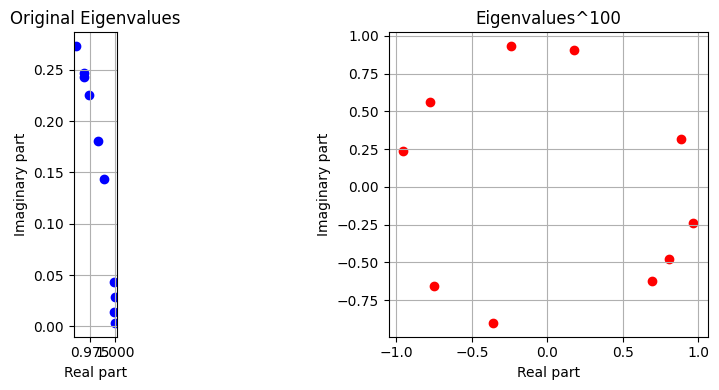

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 10          # number of eigenvalues / hidden dimension
power = 100     # how many times we "apply" the recurrence

# Sampling eigenvalues with |λ| close to 1
r_min, r_max = 0.999, 1.000  # Ensuring eigenvalues are near the unit circle
u1 = np.random.rand(N)
u2 = np.random.rand(N)
r = r_min + (r_max - r_min) * u1  # Sample radius within the range [r_min, r_max]
theta = np.pi/10 * u2            # Angle uniformly in [0, 2pi)
eigenvalues = r * np.exp(1j * theta)

# Build the diagonal matrix
Lambda = np.diag(eigenvalues)

# Exponentiate the eigenvalues by 'power'
Lambda_power = np.diag(eigenvalues ** power)

# Print original eigenvalues and their magnitudes
print("Original eigenvalues and their magnitudes:")
for idx, eig in enumerate(eigenvalues):
    print(f"Eigenvalue {idx}: {eig:.4f} with |λ| = {np.abs(eig):.4f}")

# Print the eigenvalues after raising to the 'power'
print("\nEigenvalues raised to power", power, "and their magnitudes:")
for idx, eig in enumerate(np.diag(Lambda_power)):
    print(f"Eigenvalue {idx}^({power}): {eig:.4f} with |λ| = {np.abs(eig):.4f}")

# Plotting for visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(eigenvalues.real, eigenvalues.imag, c='blue')
plt.title('Original Eigenvalues')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)

plt.subplot(1, 2, 2)
eig_power = np.diag(Lambda_power)
plt.scatter(eig_power.real, eig_power.imag, c='red')
plt.title(f'Eigenvalues^{power}')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)

plt.tight_layout()
plt.show()


In [68]:
import torch
device = torch.device("cpu")

In [71]:
# Parameters
N = 10  # number of eigenvalues
power = 100

# Generate eigenvalues with magnitude close to 1
r_min, r_max = 0.999, 1.000
r = r_min + (r_max - r_min) * torch.rand(N, device=device)
theta = torch.pi/10 * torch.rand(N, device=device)

# Create complex eigenvalues
eigenvalues = r * torch.exp(1j * theta)

# Create diagonal matrix
Lambda = torch.diag(eigenvalues)

# Compute powers
Lambda_power = torch.diag(eigenvalues ** power)

# Print statistics
print(f"Original eigenvalues magnitude range: {r.min():.4f} to {r.max():.4f}")
print(f"Power {power} eigenvalues magnitude range: {torch.abs(Lambda_power.diag()).min():.4f} to {torch.abs(Lambda_power.diag()).max():.4f}")


Original eigenvalues magnitude range: 0.9991 to 1.0000
Power 100 eigenvalues magnitude range: 0.9148 to 0.9972


In [72]:
class Mamba(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(Mamba, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.A = nn.Parameter(Lambda)
        self.B = nn.Linear(emb_size, hidden_size) 
        self.C = nn.Linear(hidden_size, emb_size)
        self.D = nn.Linear(emb_size, emb_size)
        self.norm = nn.LayerNorm(hidden_size)

        self.out = nn.Linear(emb_size, vocab_size)
        self.hidden_size = hidden_size

    def squaring(self):
        self.L = torch.diag(self.A.diag().real)
        Lambda_power = torch.diag(self.L.diag().real)
    
    def forward(self, x):
        x = self.emb(x)
        
        b = self.B(x)
        d = self.D(x)

        bigA = self.make_big_A(A, x.shape[1])

        bigH = torch.zeros(batch_size, sequence_length, 256).to(device)
        for i in range(sequence_length):
            bigH[:, i] = b[:, i] @ bigA[i]
        
        c = self.C(bigH) 
        return self.out(c+d)

class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        h = torch.zeros(1, x.shape[0], self.rnn.hidden_size).to(device)
        out, h = self.rnn(x, h)
        return self.out(out)

from time import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for model in [Mamba(emb_size=32, hidden_size=256).to(device)]:
    t0 = time()

    print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

    epochs = 3000
    batch_size = 128
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

    lossi = []
    vlossi = []

    for epoch in range(epochs):
        indexes = torch.randint(0, len(inputs)-batch_size, (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        if epoch % (epochs//10) == 0:
            print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
        
        # with torch.no_grad():
        #     pred = model(val_inputs.to(device))
        #     vloss = F.cross_entropy(pred.reshape(-1, vocab_size), val_labels.to(device).reshape(-1))
        #     vlossi.append(vloss.item())

    from scipy.ndimage import gaussian_filter1d
    plt.figure(figsize=(6, 3))  
    plt.plot(gaussian_filter1d(lossi, sigma=2), label='Loss')
    plt.plot(gaussian_filter1d(vlossi, sigma=2), label='Validation Loss')
    plt.legend()

    print(f"Training time: {time()-t0:.2f} seconds")


Millions of parameters: 0.02


AttributeError: 'Mamba' object has no attribute 'make_big_A'

In [6]:
class MLP(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(emb_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(2)])
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = F.gelu(self.fc2(x))
        return x

class Mamba(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(Mamba, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.D = nn.Linear(emb_size, emb_size)
        self.B = nn.Linear(1, hidden_size)
        self.C = nn.Linear(hidden_size, 1)
        self.A = nn.Linear(hidden_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, x, h):
        x = self.emb(x)
        
        h1 = self.B(x.view(-1, x.shape[-1], 1)) + self.A(h)
        out = self.D(x)[:, 0] + self.C(h1)[..., 0]

        h1 = self.norm(h1)
        return out, h1
    
    def make_hidden(self, batch_size, hidden_size, embedding_size):
        return torch.zeros(batch_size, embedding_size, hidden_size).to(device)
    
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(RNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, h):
        x = self.emb(x)
        out, h = self.rnn(x, h)
        out = self.fc(out)
        return out, h
    
    def make_hidden(self, batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size).to(device)


In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
from collections import deque

# Define hyperparameters
embedding_size = vocab_size
hidden_size = 256
num_layers = 2
num_epochs = 10
learning_rate = 3e-4
batch_size = 96
trailing_loss_size = 2000  # Size of the trailing loss queue

# Initialize the model, loss function, and optimizer
model = RNN(embedding_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize trailing loss queue
loss_queue = deque(maxlen=trailing_loss_size)

# Initialize list to store loss values
lossi = []


In [8]:
sequence_length = 20

# Function to create batches
def get_batches(inputs, labels, batch_size):
    for i in range(0, len(inputs) - batch_size, batch_size):
        input_batch = inputs[i:i + batch_size]
        label_batch = labels[i:i + batch_size]
        yield input_batch, label_batch

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    with tqdm(get_batches(inputs, labels, batch_size), total=len(inputs) // batch_size) as p:
        for input_batch, label_batch in p:
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)

            # Initialize hidden state
            h = model.make_hidden(batch_size, hidden_size).to(device)

            # Forward pass
            total_batch_loss = 0
            for t in range(input_batch.size(1)):
                char_input = input_batch[:, t].unsqueeze(1)
                outputs, h = model(char_input, h)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, label_batch[:, t])
                total_batch_loss += loss
                loss_queue.append(loss.item())
            
            # Calculate trailing loss
            avg_trailing_loss = sum(loss_queue) / len(loss_queue)
            p.set_description(f"Trailing Loss: {avg_trailing_loss:.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

            total_loss += total_batch_loss.item()
            lossi.append(total_batch_loss.item() / input_batch.size(1))

    avg_loss = total_loss / (len(inputs) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
# Save the model
torch.save(model.state_dict(), 'mamba_model.pth')

Trailing Loss: 2.4992:   2%|▏         | 247/11596 [00:33<25:24,  7.45it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from collections import deque

# Define hyperparameters
embedding_size = vocab_size
hidden_size = 64
num_layers = 2
num_epochs = 10
learning_rate = 3e-4
batch_size = 1
trailing_loss_size = 2000  # Size of the trailing loss queue

# Initialize the model, loss function, and optimizer
model = Mamba(embedding_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize trailing loss queue
loss_queue = deque(maxlen=trailing_loss_size)

# Initialize list to store loss values
lossi = []


In [8]:

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    with tqdm(range(0, len(inputs)-batch_size, batch_size)) as p:
        for i in p:
            input_batch = inputs[i:i+batch_size].to(device)
            label_batch = labels[i:i+batch_size].to(device)

            # Initialize hidden state
            h = model.make_hidden(batch_size, hidden_size, embedding_size).to(device)

            # Forward pass
            total_batch_loss = 0
            for t in range(input_batch.size(1)):
                char_input = input_batch[:, t].unsqueeze(1)
                outputs, h = model(char_input, h)
                #print(h.std(), h.mean())
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, label_batch[:, t])
                total_batch_loss += loss
                loss_queue.append(loss.item())
            
            # Calculate trailing loss
            avg_trailing_loss = sum(loss_queue) / len(loss_queue)
            p.set_description(f"Trailing Loss: {avg_trailing_loss:.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

            total_loss += total_batch_loss.item()
            lossi.append(total_batch_loss.item() / input_batch.size(1))

    avg_loss = total_loss / (len(inputs) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
# Save the model
torch.save(model.state_dict(), 'mamba_model.pth')

Trailing Loss: 2.4563:   6%|▌         | 64740/1113390 [04:46<1:17:18, 226.07it/s]


KeyboardInterrupt: 

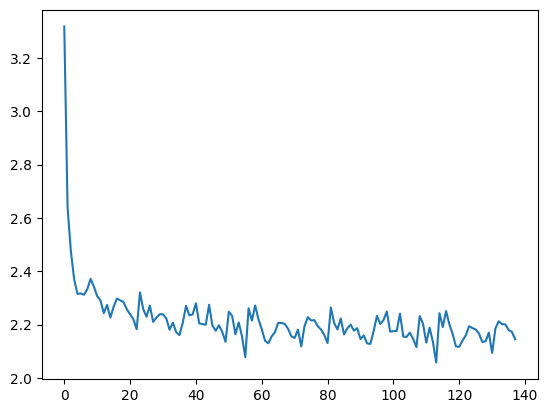

In [39]:
scale = 200  # Define the scale variable
losst = [sum(lossi[i:i+scale])/scale for i in range(0, len(lossi)-scale, scale)]
plt.plot(losst)

In [35]:

print([[p.weight.mean().item(), p.weight.std().item()] for p in [model.A, model.B, model.C, model.D]])

[[0.0007277434342540801, 0.07792990654706955], [0.043291736394166946, 0.39731210470199585], [0.0028397804126143456, 0.0289017241448164], [-0.004845542833209038, 0.2431708723306656]]
